In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

# Load dataset
try:
    dataset, info = tfds.load('oxford_flowers102:2.1.1', with_info=True, as_supervised=True)

    train_dataset = dataset['train']
    validation_dataset = dataset['validation']
    test_dataset = dataset['test']

    print(info)

except Exception as e:
    print(f"Error loading dataset: {e}")


# Function to preprocess images for a specific model
def preprocess_dataset(dataset, preprocess_func, target_size=(224, 224),batch_size=32):
    def preprocess(image, label):
        # Resize and convert to float32
        image = tf.image.resize(image, target_size)
        image = tf.cast(image, tf.float32)
        image = preprocess_func(image)  # model-specific preprocessing
        return image, label

    return (dataset
            .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.TUW9HM_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.TUW9HM_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.TUW9HM_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2

# Preprocess for ResNet50
train_res = preprocess_dataset(train_dataset, preprocess_resnet50)
val_res = preprocess_dataset(validation_dataset, preprocess_resnet50)
test_res = preprocess_dataset(test_dataset, preprocess_resnet50)

# Preprocess for VGG16
train_vgg = preprocess_dataset(train_dataset, preprocess_vgg16)
val_vgg = preprocess_dataset(validation_dataset, preprocess_vgg16)
test_vgg = preprocess_dataset(test_dataset, preprocess_vgg16)

# Preprocess for MobileNetV2
train_mobile = preprocess_dataset(train_dataset, preprocess_mobilenetv2)
val_mobile = preprocess_dataset(validation_dataset, preprocess_mobilenetv2)
test_mobile = preprocess_dataset(test_dataset, preprocess_mobilenetv2)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

resnet50_model = ResNet50(weights='imagenet', include_top=False,input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(resnet50_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(102, activation='softmax')(x)

resnet50_model = Model(inputs=resnet50_model.input, outputs=predictions)
resnet50_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

vgg_model = VGG16(weights='imagenet', include_top=False,input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(vgg_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(102, activation='softmax')(x)
vg_model = Model(inputs=vgg_model.input, outputs=predictions)
vg_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

mobilenet_model = MobileNetV2(weights='imagenet', include_top=False,input_shape=(32, 32, 3))

x = GlobalAveragePooling2D()(mobilenet_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(102, activation='softmax')(x)
mb_model = Model(inputs=mobilenet_model.input, outputs=predictions)
mb_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/tmp/ipython-input-8829608.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_model = MobileNetV2(weights='imagenet', include_top=False,input_shape=(32, 32, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
epochs = 3

print(len(resnet50_model.layers))
print(len(vg_model.layers))
print(len(mb_model.layers))

#Fine tuning for Resnet50
for layer in resnet50_model.layers[:-30]:
  layer.trainable = False

for layer in resnet50_model.layers[-30:]:
  layer.trainable = True

history_restnet50 = resnet50_model.fit(train_res, epochs=epochs, validation_data=val_res)

# Fine tuning for VGG16

for layer in vg_model.layers[:-5]:
  layer.trainable = False

for layer in vg_model.layers[-5:]:
  layer.trainable = True

history_vgg = vg_model.fit(train_vgg, epochs=epochs, validation_data=val_vgg)

# #Fine tuning for Mobilenet
# for layer in mb_model.layers[:-40]:
#   layer.trainable = False

# for layer in mb_model.layers[-40:]:
#   layer.trainable = True

# history_mobilenet = mb_model.fit(train_mobile, epochs=epochs, validation_data=val_mobile)

178
22
157
Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 696ms/step - accuracy: 0.2073 - loss: 4.1589 - val_accuracy: 0.0559 - val_loss: 78.5678
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.8382 - loss: 0.6832 - val_accuracy: 0.0941 - val_loss: 33.5179
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 233ms/step - accuracy: 0.9604 - loss: 0.1694 - val_accuracy: 0.1461 - val_loss: 37.8052
Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 859ms/step - accuracy: 0.0659 - loss: 8.5673 - val_accuracy: 0.2206 - val_loss: 3.4318
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 372ms/step - accuracy: 0.3436 - loss: 2.7248 - val_accuracy: 0.4137 - val_loss: 2.7216
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 365ms/step - accuracy: 0.6746 - loss: 1.2288 - val_accuracy: 0.5245 - val_loss: 2.1461


In [ ]:
acc_resnet50    = resnet50_model.evaluate(test_res)[1]
acc_vgg16       = vg_model.evaluate(test_vgg)[1]
# acc_mobilenetv2 = mb_model.evaluate(test_mobile)[1]

print(f'ResNet50 Accuracy: {acc_resnet50:.2f}')
print(f'VGG16 Accuracy: {acc_vgg16:.2f}')
# print(f'MobileNetV2 Accuracy: {acc_mobilenetv2:.2f}')

193/193 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - accuracy: 0.1302 - loss: 39.2330
193/193 ━━━━━━━━━━━━━━━━━━━━ 36s 188ms/step - accuracy: 0.5000 - loss: 2.3451
ResNet50 Accuracy: 0.13
VGG16 Accuracy: 0.50


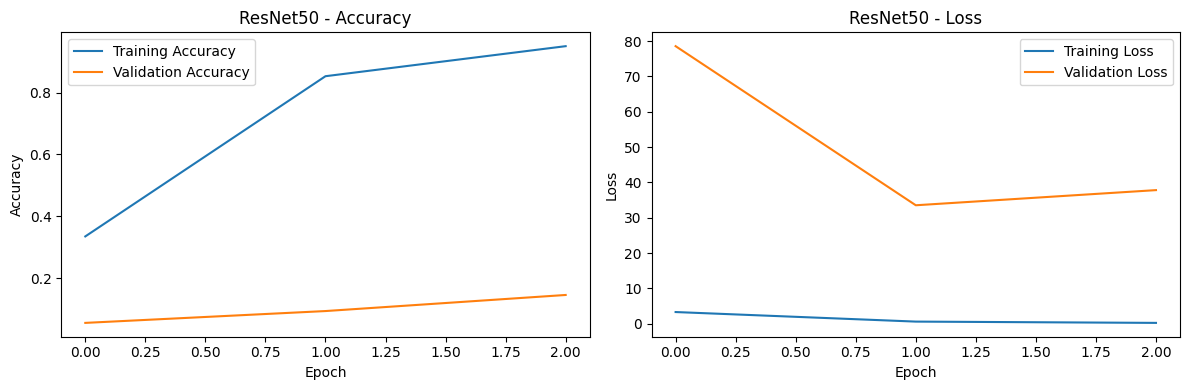

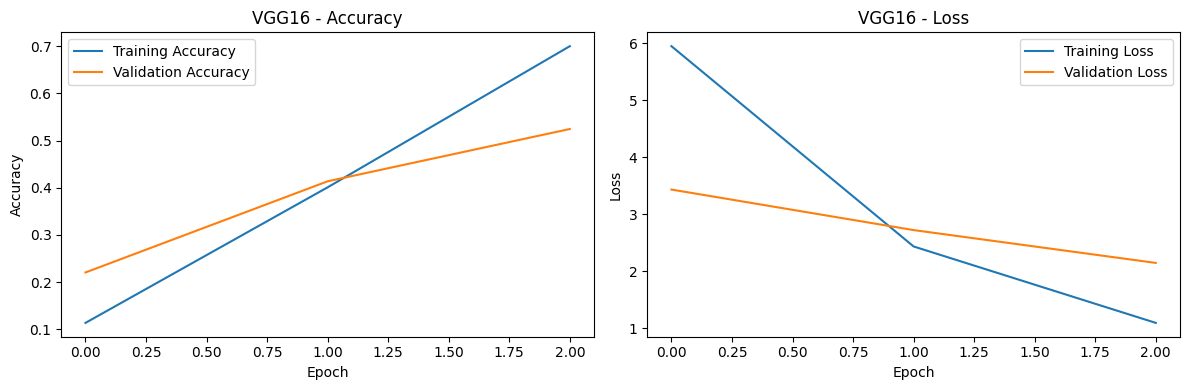

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    """Plots training and validation accuracy and loss."""
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot history for each model
plot_history(history_restnet50, 'ResNet50')
plot_history(history_vgg, 'VGG16')
